In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.algorithms.optimization_algorithm import OptimizationResult
from time import time
from getpass import getpass
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

/var/folders/m7/1jm4cxtj20b5f6lhz8lzbxzh0000gn/T/ipykernel_39426/1170161966.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/m7/1jm4cxtj20b5f6lhz8lzbxzh0000gn/T/ipykernel_39426/1170161966.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.a

In [112]:
import pandas as pd

dataset_folder = "datasets"
symbols = ["AAPL", "GOOG", "TSLA", "MSFT"]

data = pd.DataFrame()

# for symbol in symbols:
#     filepath = f"{dataset_folder}/{symbol}.csv"
#     try:
#         df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
#         # Assuming 'Close' column is present for calculating returns
#         df[f'{symbol}_Return'] = df['Close'].pct_change()
#         data = pd.concat([data, df[[f'{symbol}_Return']]], axis=1)
        
#         # Print the first few rows of each DataFrame
#         print(f"First few rows of data for {symbol}:")
#         print(df.head())
#         print("\n")  # Adding a newline for better readability

#     except FileNotFoundError:
#         print(f"File for {symbol} not found. Skipping this symbol.")
#     except pd.errors.EmptyDataError:
#         print(f"File for {symbol} is empty. Skipping this symbol.")
#     except Exception as e:
#         print(f"An error occurred while processing {symbol}: {e}")


# specify the start date and end date of stock
start_date = '2023-01-01'
end_date = '2024-01-01'

for symbol in symbols:
    filepath = f"{dataset_folder}/{symbol}.csv"
    try:
        df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
        
        # Filter the data for the date range
        df = df.loc[start_date:end_date]
        
        # Calculate returns
        df[f'{symbol}_Return'] = df['Close'].pct_change()
        
        # Concatenate the returns column to the data DataFrame
        data = pd.concat([data, df[[f'{symbol}_Return']]], axis=1)

        # Print the first few rows of each DataFrame
        print(f"First few rows of data for {symbol}:")
        print(df.head())
        print("\n")  # Adding a newline for better readability

    except FileNotFoundError:
        print(f"File for {symbol} not found. Skipping this symbol.")
    except pd.errors.EmptyDataError:
        print(f"File for {symbol} is empty. Skipping this symbol.")
    except Exception as e:
        print(f"An error occurred while processing {symbol}: {e}")




First few rows of data for AAPL:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-02-13  150.949997  154.259995  150.919998  153.850006  153.033173   
2023-02-14  152.119995  153.770004  150.860001  153.199997  152.386612   
2023-02-15  153.110001  155.500000  152.880005  155.330002  154.505295   
2023-02-16  153.509995  156.330002  153.350006  153.710007  152.893906   
2023-02-17  152.350006  153.000000  150.850006  152.550003  151.740051   

              Volume  AAPL_Return  
Date                               
2023-02-13  62199000          NaN  
2023-02-14  61707600    -0.004225  
2023-02-15  65573800     0.013903  
2023-02-16  68167900    -0.010429  
2023-02-17  59144100    -0.007547  


First few rows of data for GOOG:
                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
202

In [50]:
# Calculate mean returns (mu) and covariance matrix
mean_returns = data.mean() * 252  # Annualize the mean returns
covariance_matrix = data.cov() * 252  # Annualize the covariance matrix

# Print results
print("Annualized Mean Returns (mu):")
print(mean_returns)

print("\nAnnualized Covariance Matrix:")
print(covariance_matrix)

Annualized Mean Returns (mu):
AAPL_Return    0.274150
GOOG_Return    0.488144
TSLA_Return    0.400766
MSFT_Return    0.399890
dtype: float64

Annualized Covariance Matrix:
             AAPL_Return  GOOG_Return  TSLA_Return  MSFT_Return
AAPL_Return     0.036743     0.026928     0.040837     0.024459
GOOG_Return     0.026928     0.076112     0.048405     0.029618
TSLA_Return     0.040837     0.048405     0.245285     0.035337
MSFT_Return     0.024459     0.029618     0.035337     0.055421


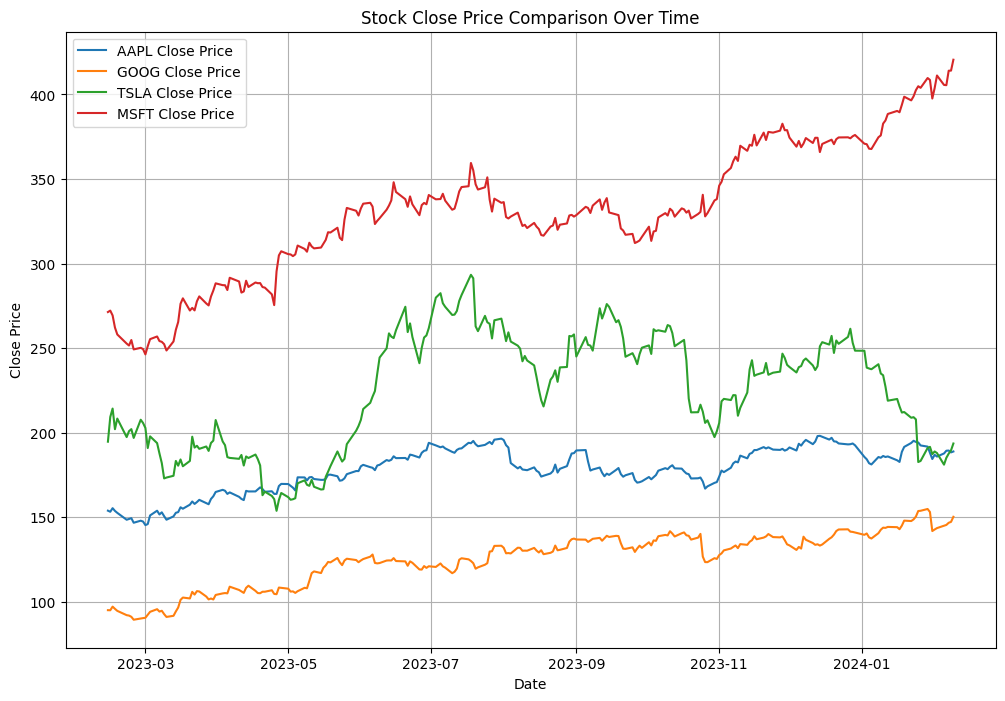

In [51]:
plt.figure(figsize=(12, 8))

for symbol in symbols:
    filepath = f"{dataset_folder}/{symbol}.csv"
    try:
        df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
        
        # Plotting the 'Close' prices on the same graph
        plt.plot(df['Close'], label=f'{symbol} Close Price')

    except FileNotFoundError:
        print(f"File for {symbol} not found. Skipping this symbol.")
    except pd.errors.EmptyDataError:
        print(f"File for {symbol} is empty. Skipping this symbol.")
    except Exception as e:
        print(f"An error occurred while processing {symbol}: {e}")

# Setting the title, labels and legend
plt.title('Stock Close Price Comparison Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

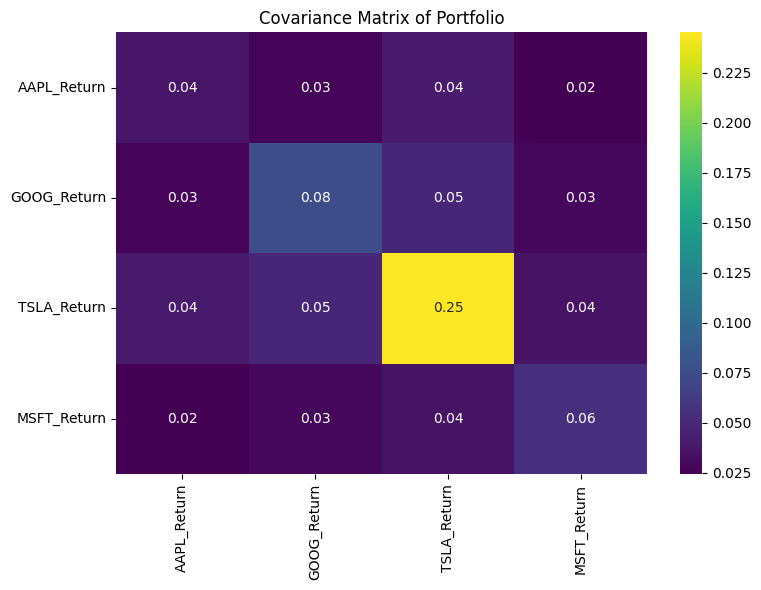

In [52]:
import seaborn as sns
# Plot the covariance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Setting titles and labels
plt.title('Covariance Matrix of Portfolio')
plt.xticks(ticks=np.arange(0.5, len(covariance_matrix.columns), 1), labels=covariance_matrix.columns, rotation=90)
plt.yticks(ticks=np.arange(0.5, len(covariance_matrix.index), 1), labels=covariance_matrix.index, rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [53]:
print("Length of mean_returns:", len(mean_returns))
print("Shape of covariance_matrix:", covariance_matrix.shape)

Length of mean_returns: 4
Shape of covariance_matrix: (4, 4)


In [60]:
num_assets = 4
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

# Convert to numpy array if mean_returns is a pandas Series and covariance_matrix is a pandas DataFrame
expected_returns = mean_returns.values
covariances = covariance_matrix.values

portfolio = PortfolioOptimization(
    expected_returns=expected_returns,
    covariances=covariances,
    risk_factor=q,
    budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.01837169404201073*x_0^2 + 0.026927914500107283*x..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [61]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Solving the problem classically using NumPyMinimumEigensolver for reference 


In [62]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.7927

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [0 1 0 1]	-0.7927		1.0000


## Solution using `SamplingVQE`
We can now use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) to solve the problem. We will specify the optimizer and variational form to be used.

In [63]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.7927

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 0 1]	-0.6035		0.8145
 [0 1 1 0]	-0.6798		0.1260
 [0 1 0 1]	-0.7927		0.0283
 [1 1 0 1]	-0.9970		0.0098
 [0 1 1 1]	-0.9870		0.0078
 [1 0 1 1]	-0.8054		0.0049
 [0 0 0 1]	-0.3722		0.0029
 [0 0 1 1]	-0.6150		0.0020
 [0 0 1 0]	-0.2781		0.0020
 [1 1 1 0]	-0.8678		0.0010
 [1 1 1 1]	-1.1506		0.0010


/Users/nich/Desktop/Qillers/virenv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


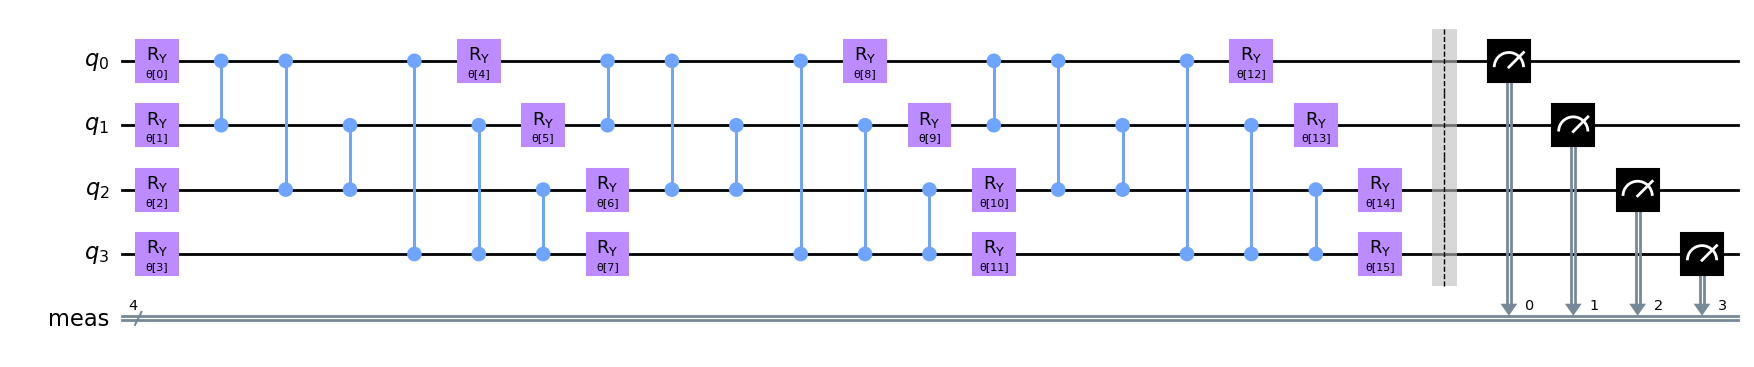

In [65]:
ry.decompose().draw("mpl") #Displaying the Ansatz circuit

### Solution using `QAOA`

We also show here a result using the Quantum Approximate Optimization Algorithm (`QAOA`). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [109]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 1.], value -0.7927

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 0 1 0]	-0.4931		0.2012
 [0 0 1 0]	-0.2781		0.1250
 [1 0 0 1]	-0.6035		0.1250
 [1 0 0 0]	-0.2558		0.1094
 [0 0 1 1]	-0.6150		0.0957
 [1 1 0 0]	-0.6789		0.0586
 [0 1 1 0]	-0.6798		0.0518
 [1 1 0 1]	-0.9970		0.0469
 [0 1 0 1]	-0.7927		0.0439
 [0 1 1 1]	-0.9870		0.0420
 [1 1 1 1]	-1.1506		0.0342
 [1 0 1 1]	-0.8054		0.0244
 [0 0 0 1]	-0.3722		0.0176
 [0 0 0 0]	0.0000		0.0127
 [1 1 1 0]	-0.8678		0.0107
 [0 1 0 0]	-0.4501		0.0010


In [108]:


# # # Setup the initial state for the QAOA circuit
# qaoa_ansatz = qaoa_mes.ansatz
# qaoa_ansatz.decompose().draw("mpl") #Displaying the Ansatz circuit


None
